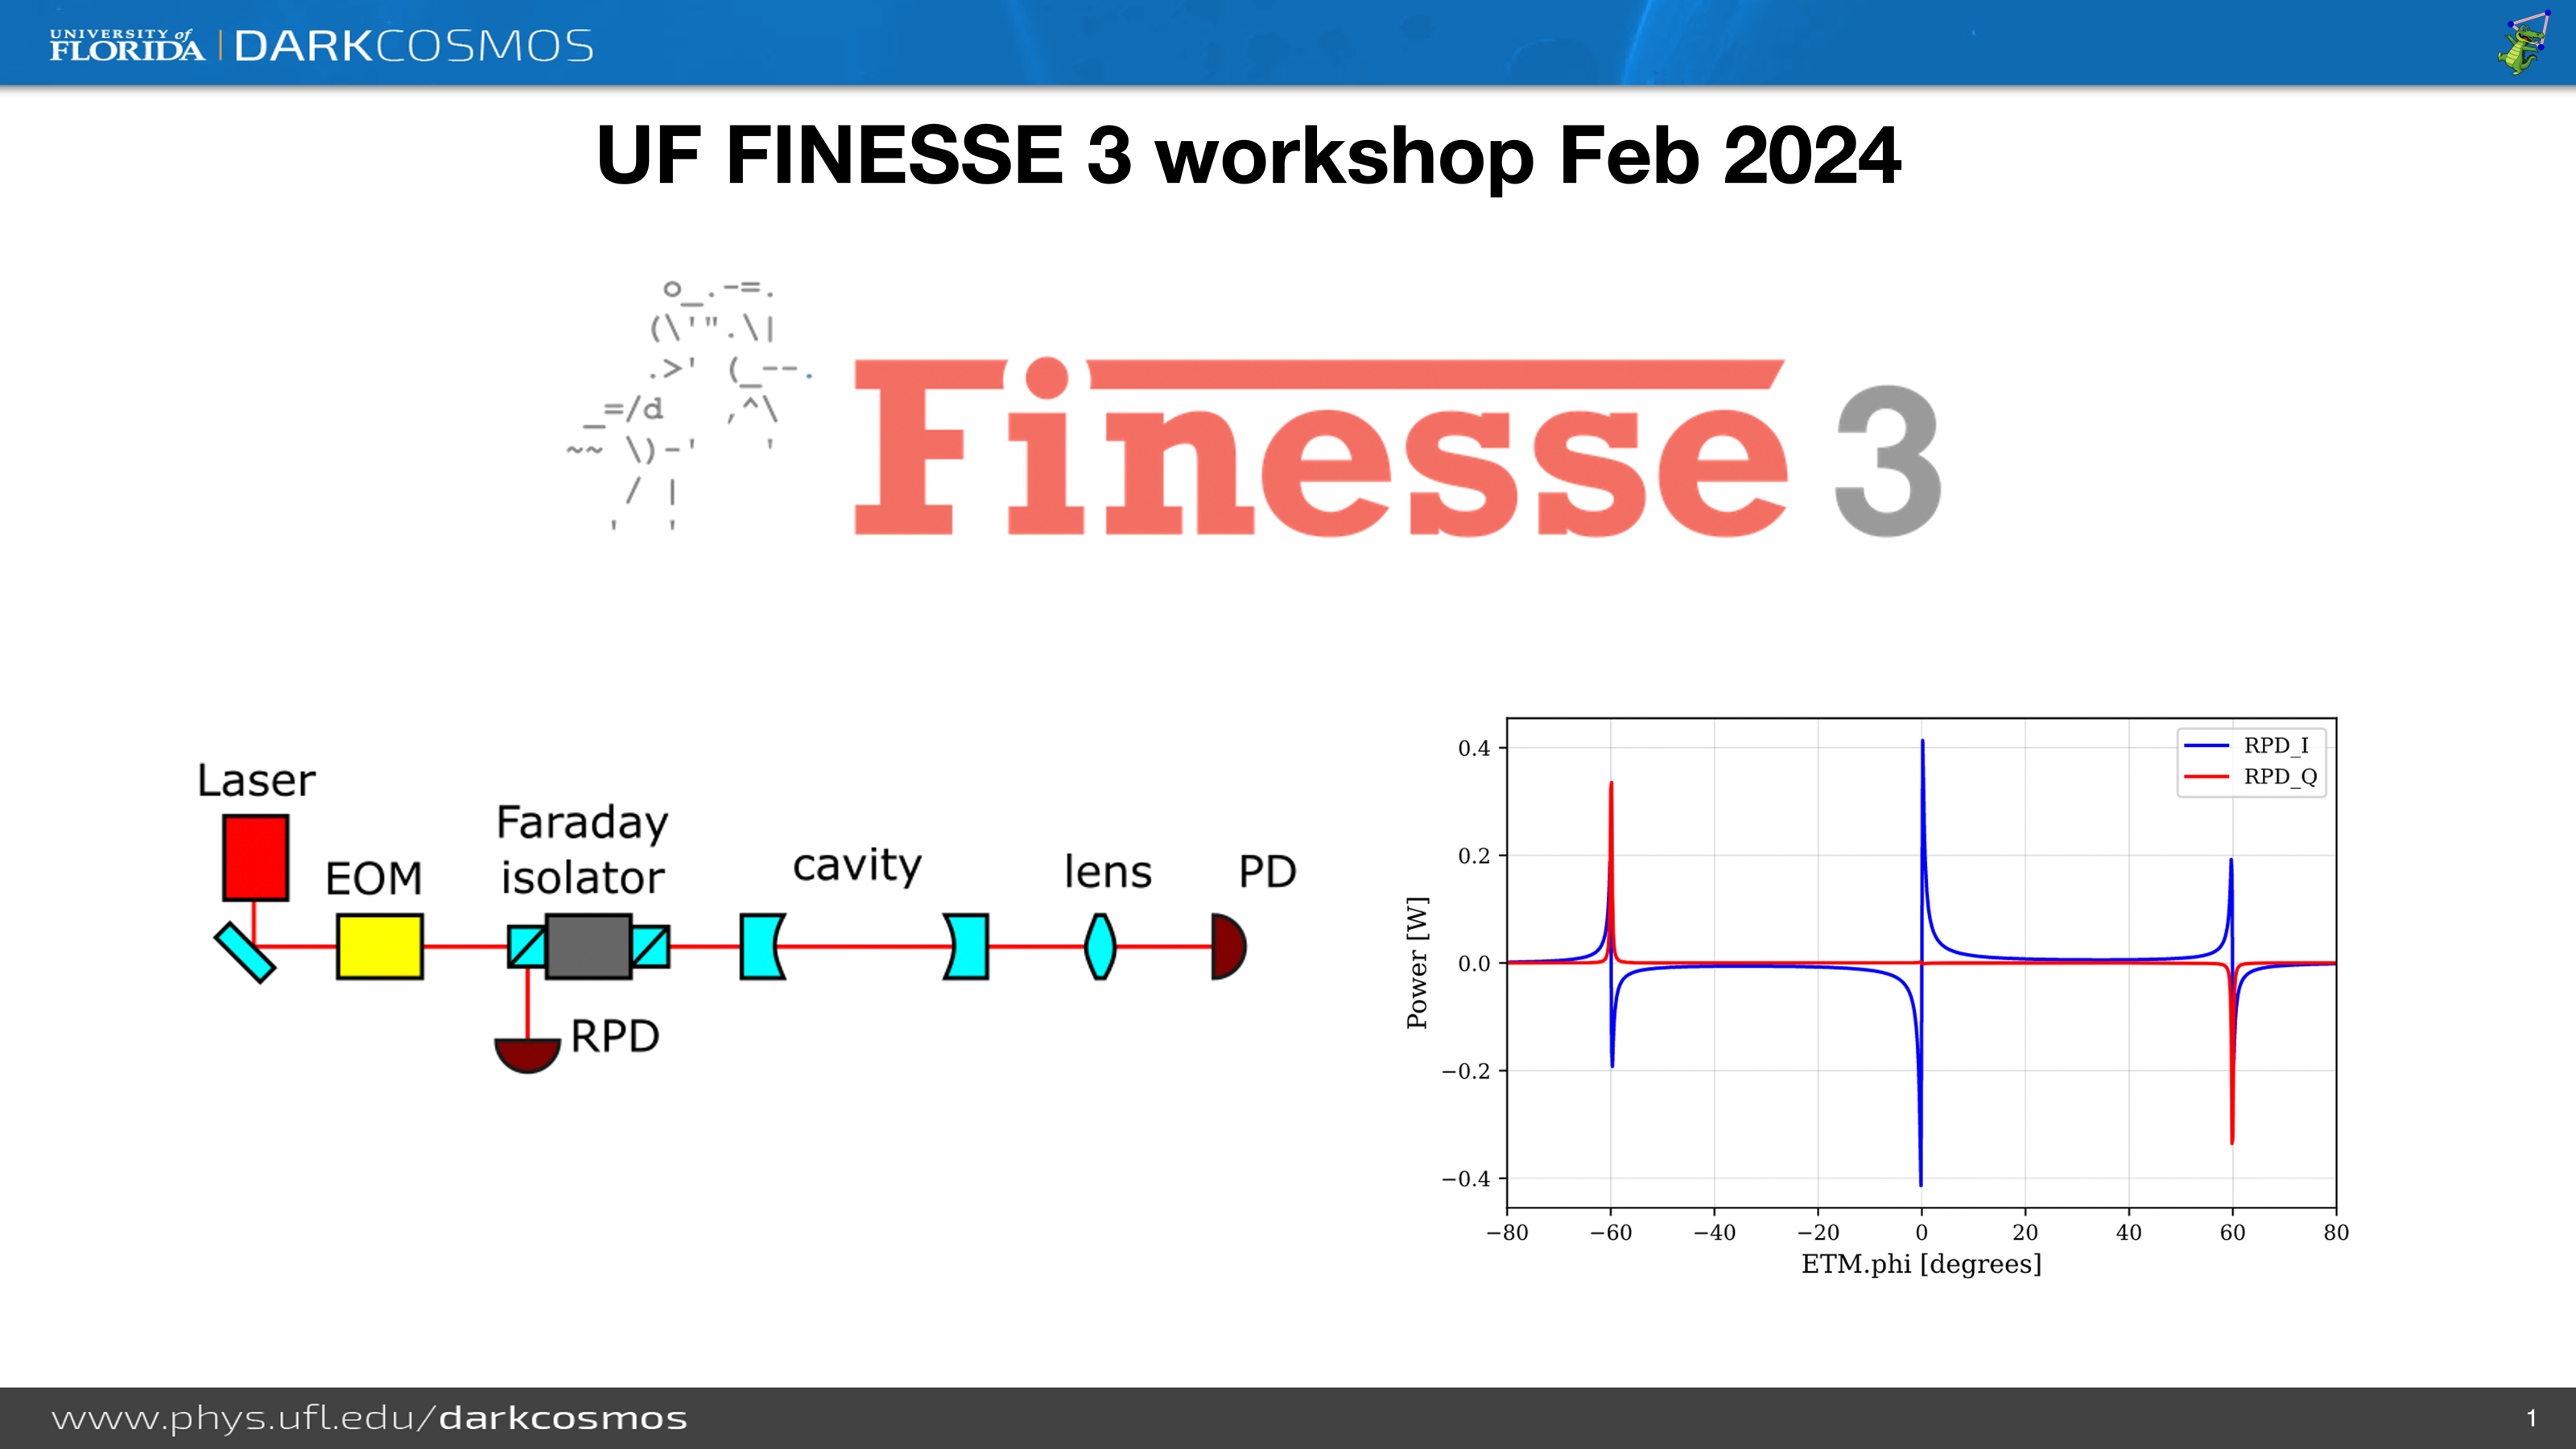

In [17]:
import pytest
import finesse
import finesse.ligo
from finesse.ligo.factory import ALIGOFactory
from finesse.ligo.actions import InitialLockLIGO, DARM_RF_to_DC
from finesse.plotting import bode
import finesse.analysis.actions as fac
# import finesse.analysis.actions as fa
from finesse.ligo.factory import aligo
import matplotlib.pylab as plt
import sympy as sym
from scipy.integrate import quad
from finesse.ligo.ASC_controllers import get_controller
from finesse.ligo.suspension import QUADSuspension
from scipy.integrate import *
import scipy
import finesse.components as fc
import finesse.detectors as det
from finesse.analysis.actions import FrequencyResponse
import cmath
import math
from sympy import integrate
import numpy as np
from finesse.analysis.actions.axes import Noxaxis
from finesse.analysis.actions import axes
from IPython.display import Image
from matplotlib.lines import Line2D
from finesse.tracing.tools import compute_abcd
from finesse import constants as ct 
import subprocess
git_repo_path = subprocess.check_output(['git', 'rev-parse', '--show-toplevel']).strip().decode('utf-8')
import sys
from pathlib import Path
sys.path.append(str(Path(git_repo_path)))

finesse.configure(plotting=True)



In [28]:
# Start with creating a new model. 
base = finesse.Model()
#Model is Optical configuration class for handling models of interferometers.

LASER = base.add(fc.Laser("LASER", P=1e-3,phase=0))


#Let's add 2 mirrors to build a simple cavity.
#We will use the Mirror component from the components module.
#The Mirror component has a reflectivity (R), transmissivity (T) and losses (L) parameter.
# R+T+L should be equal to 1.
#We will also add a space between the laser and the first mirror, and between the two mirrors.
#The Space component has a length (L) parameter.
#The portA and portB parameters are used to connect components.


M1 = base.add(fc.Mirror("M1", R=0.99, L=0))
base.add(fc.Space('sLaser_M1',portA=LASER.p1,portB=M1.p1,L=1)) #L=0 by default
M2 = base.add(fc.Mirror("M2", R=0.999, L=0))
base.add(fc.Space('sM1_M2',portA=M1.p2,portB=M2.p1,L=1))




<'sM1_M2' @ 0x1162b5890 (Space)>

<div style="background-color:white; padding:10px;">
  <img src="../../../../Downloads/line.svg" alt="line" />
</div>

In [29]:
base.add(det.PowerDetector('pdinc', M1.p1.i)); # Incident power
base.add(det.PowerDetector('pdrefl', M1.p1.o)); # Reflected power
base.add(det.PowerDetector('pdtrans', M2.p2.o)); # transmitted power
base.add(det.PowerDetector('pdcirc', M1.p2.i)); # Circulating power



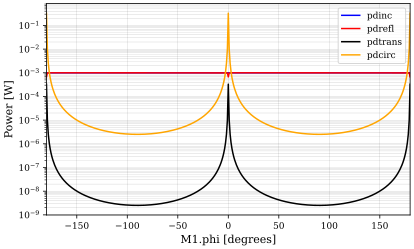

{finesse.detectors.powerdetector.PowerDetector: <Figure size 576x355.968 with 1 Axes>,
 'pdinc': <Figure size 576x355.968 with 1 Axes>,
 'pdrefl': <Figure size 576x355.968 with 1 Axes>,
 'pdtrans': <Figure size 576x355.968 with 1 Axes>,
 'pdcirc': <Figure size 576x355.968 with 1 Axes>}

In [30]:
# out = base.run("xaxis(M1.phi, lin, -180, 180, 400)")
out=base.run(fac.Xaxis(M1.phi,'lin', -180, 180, 400))
out.plot(logy=True)

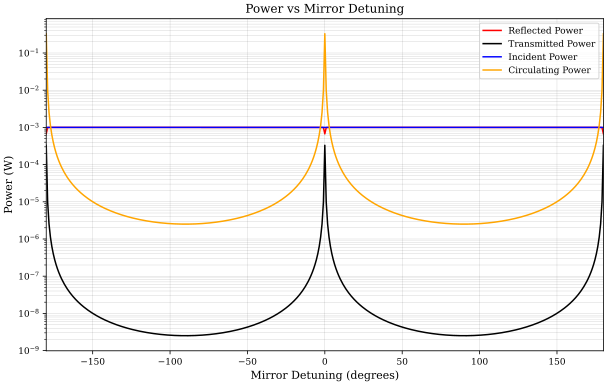

In [32]:
# OR we can extract the data and plot it using matplotlib
x_axis= out.x1 #This is M1.phi (the detuning of the mirror)
reflected_power = out['pdrefl'] #This is the reflected power
transmitted_power = out['pdtrans'] #This is the transmitted power
incident_power = out['pdinc'] #This is the incident power
circulating_power = out['pdcirc'] #This is the circulating power

plt.figure(figsize=(10, 6))
plt.semilogy(x_axis, reflected_power, label='Reflected Power', color='red')
plt.plot(x_axis, transmitted_power, label='Transmitted Power', color='black')
plt.plot(x_axis, incident_power, label='Incident Power', color='blue')
plt.plot(x_axis, circulating_power, label='Circulating Power', color='orange')
plt.xlabel('Mirror Detuning (degrees)') 
plt.ylabel('Power (W)')
plt.title('Power vs Mirror Detuning')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# now, this all was using planewaves . 

In [ ]:


M2 = base.add(fc.Mirror("M2", R=.99, L=0))
reflection_lens=base.add(fc.Lens('reflection_lens',f=0.3))
nothing_QPD1 = base.add(fc.Nothing("nothing_QPD1"))

sL9_BS=base.add(fc.Space('sL9_CavIn',portA=EOM.p2,portB=BS.p3,L=0.3))  #5475e-2
sCavIn_CavOut=base.add(fc.Space('sCavIn_CavOut',portA=CavIn.p1,portB=CavOut.p1,L=1))
sBS_CavIn=base.add(fc.Space('sBS_CavIn',portA=BS.p1,portB=CavIn.p2,L=0.0))
sBS_lens=base.add(fc.Space("sBS_lens",portA=BS.p2,portB=reflection_lens.p1,L=0.0))
slens_QPD=base.add(fc.Space("slens_QPD",portA=reflection_lens.p2,portB=nothing_QPD1.p1,L=0.35))
base.add(fc.gauss.Gauss("g1",node=base.EOM.p2.o,w0=(0.000615351666202293), z=(-0.7999999999999998)))


###### We can either define a cavity or assign a gauss command 

base.add(fc.Cavity('BT_Cav', source=CavOut.p1.o))
# print(base.cavities)
parameters_table=base.BT_Cav.info_parameter_table()
print(parameters_table)

# print(base.mismatches_table())

base.add(det.PowerDetector('pdrefl_cav', CavIn.p2.o)); # Incident power
# base.add(det.PowerDetector('pdcirc', CavOut.p1.i)); # Incident power
base.add(det.PowerDetector('pdtrans', CavOut.p2.o)); # transmitted power
base.add(det.PowerDetector('pdrefl', nothing_QPD1.p1.i)); # reflected power
base.add(det.PowerDetectorDemod1('rfpd', nothing_QPD1.p1.i, EOM.f,phase=0))
AD_HG00_carrier_before=base.add(det.AmplitudeDetector("AD_HG00_carrier_before",n=0,m=0,f=base.LASER.f,node=base.CavIn.p2.i))
AD_HG00_USB_before=base.add(det.AmplitudeDetector("AD_HG00_USB_before",n=0,m=0,f=base.EOM.f,node=base.CavIn.p2.i))
AD_HG00_LSB_before=base.add(det.AmplitudeDetector("AD_HG00_LSB_before",n=0,m=0,f=-base.EOM.f,node=base.CavIn.p2.i))

AD_HG00_carrier=base.add(det.AmplitudeDetector("AD_HG00_carrier",n=0,m=0,f=base.LASER.f,node=base.CavIn.p2.o))
AD_HG00_USB=base.add(det.AmplitudeDetector("AD_HG00_USB",n=0,m=0,f=base.EOM.f,node=base.CavIn.p2.o))
AD_HG00_LSB=base.add(det.AmplitudeDetector("AD_HG00_LSB",n=0,m=0,f=-base.EOM.f,node=base.CavIn.p2.o))
AD_HG20_carrier=base.add(det.AmplitudeDetector("AD_HG20_carrier",n=2,m=0,f=base.LASER.f,node=base.CavIn.p2.o))
AD_HG02_carrier=base.add(det.AmplitudeDetector("AD_HG02_carrier",n=0,m=2,f=base.LASER.f,node=base.CavIn.p2.o))


AD_HG20_LSB=base.add(det.AmplitudeDetector("AD_HG20_LSB",n=2,m=0,f=-base.EOM.f,node=base.CavIn.p2.o))
AD_HG02_LSB=base.add(det.AmplitudeDetector("AD_HG02_LSB",n=0,m=2,f=-base.EOM.f,node=base.CavIn.p2.o))

AD_HG20_USB=base.add(det.AmplitudeDetector("AD_HG20_USB",n=2,m=0,f=base.EOM.f,node=base.CavIn.p2.o))
AD_HG02_USB=base.add(det.AmplitudeDetector("AD_HG02_USB",n=0,m=2,f=base.EOM.f,node=base.CavIn.p2.o))

base.trace_forest
sol = base.run(fac.Xaxis("LASER.f", "lin", -25e6, 25e6, 300))
sol_no_xaxis=base.run()

plt.plot(sol.x[0], sol['pdrefl'],label='QPD_reflection')
plt.plot(sol.x[0], sol['pdrefl_cav']/2,'--',label='cav_reflection')
plt.plot(sol.x[0], (np.abs(sol['AD_HG00_USB'])**2+np.abs(sol['AD_HG00_LSB'])**2+np.abs(sol['AD_HG00_carrier'])**2)/2,'-.',label='AD calculated')
# plt.plot(sol.x[0], sol['rfpd'],label='PDH')

# sol.plot()
print("Carrier phase before cavity", np.angle(sol_no_xaxis['AD_HG00_carrier_before'])*180/np.pi)
print("Carrier phase after the cavity", np.angle(sol_no_xaxis['AD_HG00_carrier'])*180/np.pi)

print("USB Before",np.angle(sol_no_xaxis['AD_HG00_USB_before'])*180/np.pi,"LSB Before",np.angle(sol_no_xaxis['AD_HG00_LSB_before'])*180/np.pi)
print("USB After",np.angle(sol_no_xaxis['AD_HG00_USB'])*180/np.pi,"LSB After",np.angle(sol_no_xaxis['AD_HG00_LSB'])*180/np.pi)

print(np.angle(sol_no_xaxis['AD_HG20_carrier'])*180/np.pi,np.angle(sol_no_xaxis['AD_HG02_carrier'])*180/np.pi)


test_path = base.path(from_node=base.EOM.p2,to_node=base.nothing_QPD1.p1)

prop1=finesse.tracing.tools.propagate_beam(path=test_path)
print(prop1.total_acc_gouy)
prop1.plot()
print(prop1)
print(prop1.total_acc_gouy)
plt.show()

#%%
sol2=base.run(fac.Xaxis(base.LASER.f,'lin',-base.BT_Cav.FSR,base.BT_Cav.FSR,400))
sol3=base.run(fac.Xaxis(base.CavOut.phi,'lin',-180,180,400))

plt.semilogy(-sol2.x1,sol2['pdtrans'],label='laser.f')
plt.semilogy(sol3.x1*base.BT_Cav.FSR/180,sol3['pdtrans'],'--',label='CavOut.ø')

plt.axvline(x=-2*base.BT_Cav.mode_separation_x, linestyle='--',color='green',label='2∆f')
plt.legend()
plt.show()
